# Plan



Generate some low dimensional dynamics
Then add space on top of that




In [1]:
#%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
from functools import partial
from mpl_toolkits import mplot3d

seaborn.set(font_scale=1.5,style='ticks')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# Run with jax

In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


In [4]:
def predict(Ahat,x,y,n,dim):
    Ahat = jnp.reshape(Ahat,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(Ahat,n),x)-y)**2)


#predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
#grad_predict_funs = [grad(i) for i in predict_funs]

# Now do it properly with constraints

In [5]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [6]:
def construct_M(skewM,dim):
    """ Perform Caley transform"""
    return (jnp.eye(dim) - skewM)@jnp.linalg.inv(jnp.eye(dim)+skewM)

In [7]:
def predict(T,x,y,n,dim):
    transition_matrix = jnp.reshape(T,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(transition_matrix,n),x)-y)**2)


#predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
#grad_predict_funs = [grad(i) for i in predict_funs]

In [8]:
def predict_all(params,x,dim,basis_tensor):

    err = 0
    nT = len(x)
    k = 0
    skewM = jnp.einsum('i...,i...',params,basis_tensor)
    M = construct_M(skewM,dim)
    #print(M.shape)
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict(M,x[start_state],x[pred_state],n_fwd,dim)
            k += 1
    mse = err/k
    #print(mse)
    return mse


In [9]:
def grad_wrapper(params,x,dim,basis_tensor):
    grad = grad_predict_all(jnp.array(params),x,dim,basis_tensor)
    grad = np.array(grad)
    #print(grad)
    return grad

In [10]:
def caley_transform(skewM,dim):
    """ Perform Caley transform"""
    return (np.eye(dim) - skewM)@np.linalg.inv(np.eye(dim)+skewM)

## Generate Data

# Get this to work with cell activity with structured noise

In [18]:
np.random.seed(99)
n_neurons = 120
dim = 5
nT = 9

frac_noise_dynamics = 1.

x0 = np.random.normal(size=(dim,1))


a_params = np.random.normal(size=int(dim*(dim-1)/2))

basis_tensor = get_basis_tensor(dim)
skewM = np.einsum('i...,i...',a_params,basis_tensor)
A = caley_transform(skewM,dim)

#x0_2 = np.linalg.matrix_power(A,30)@x0
x0_2 = np.random.normal(size=(dim,1))
assert(np.logical_not(np.allclose(x0,x0_2)))

#A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)
x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])
x_2 = np.array([np.linalg.matrix_power(A,i)@x0_2 for i in range(nT)])

x = frac_noise_dynamics*x + (1-frac_noise_dynamics)*np.random.normal(size=x.shape)
x_2 = frac_noise_dynamics*x_2 + (1-frac_noise_dynamics)*np.random.normal(size=x.shape)


W = np.random.normal(size=(n_neurons,dim))
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [66]:
def simulate_dynamics(dim=5,nT=9,frac_noise_dynamics=.7):
    """ Get latent states simulated with unitary dynamics """
    
    x0 = np.random.normal(size=(dim,1))
    a_params = np.random.normal(size=int(dim*(dim-1)/2))

    basis_tensor = get_basis_tensor(dim)
    skewM = np.einsum('i...,i...',a_params,basis_tensor)
    A = caley_transform(skewM,dim)

    #x0_2 = np.linalg.matrix_power(A,30)@x0
    x0_2 = np.random.normal(size=(dim,1))
    assert(np.logical_not(np.allclose(x0,x0_2)))

    #A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)
    x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])
    x_2 = np.array([np.linalg.matrix_power(A,i)@x0_2 for i in range(nT)])

    x = frac_noise_dynamics*x + (1-frac_noise_dynamics)*np.random.normal(size=x.shape)
    x_2 = frac_noise_dynamics*x_2 + (1-frac_noise_dynamics)*np.random.normal(size=x.shape)


    W = np.random.normal(size=(n_neurons,dim))
    basis_tensor = get_basis_tensor(dim)
    n_bases = basis_tensor.shape[0]
    
    return x,x2

In [67]:
evals, evecs = np.linalg.eig(A)

In [68]:
evecs[:,0]

array([-0.64089088+0.j,  0.48850702+0.j, -0.14728939+0.j, -0.55874515+0.j,
       -0.12934242+0.j])

In [19]:
def get_spatial_tuning(poke_pos,peak_loc,width):
    """"""
    #for i in range(9):
    distance_matrix = np.abs((poke_pos[peak_loc]-poke_pos)**2).sum(axis=1)
    fr = norm(scale=width).pdf(distance_matrix)
    return fr#distance_matrix
        
def get_task_tuning_line(seq,peak_loc,width):
    task_dists = np.abs(peak_loc-np.arange(9))
#     fr = norm(scale=width).pdf(task_dists)
    fr = np.sin(task_dists)
    return fr[seq]#task_dists[seq]#[task_dists[i] for i in seq]#fr#[fr[i] for i in seq]

In [20]:
from scipy.stats import norm

np.random.seed(99)

act_matrix = []
act_matrix2 = []
space_order2 = np.random.permutation(np.arange(9))
space_order2_inv = [list(space_order2).index(i) for i in range(9)]
for nix in range(n_neurons):
    
    frac_space = np.random.uniform(0,1)
    peak_space = np.random.randint(0,9)
    std_space = np.random.randint(1000,12000)
    
    lamda1 = get_spatial_tuning(poke_pos,peak_space,std_space)
    lamda1 = lamda1/np.max(lamda1)
    
    
    neuron_state_couple = np.random.normal(size=(dim))
    
    lamda2 = np.squeeze(x)@neuron_state_couple
    lamda2_2 = np.squeeze(x_2)@neuron_state_couple

    
    activity = frac_space*lamda1 + (1-frac_space)*lamda2 + np.random.normal(scale=.1,size=9)
    act_matrix.append(activity.copy())
    
    activity2 = frac_space*lamda1[space_order2] + (1-frac_space)*lamda2_2 + np.random.normal(scale=.1,size=9)
    act_matrix2.append(activity2.copy())
act_matrix = np.array(act_matrix).T
act_matrix2 = np.array(act_matrix2).T

In [22]:
REMOVE_SPACE = False

In [23]:
act_matrix[0][:5]

array([ 1.18721003,  0.70927152, -1.02814495, -1.53366823, -1.98298348])

In [24]:
if REMOVE_SPACE:
    spatial_response = (act_matrix + act_matrix2[space_order2_inv])/2.
    act_matrix2 = act_matrix2 - spatial_response[space_order2]
    act_matrix = act_matrix - spatial_response

In [25]:
grad_predict_all = grad(predict_all)

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca_dim = 5
pca = PCA(n_components=pca_dim)

In [28]:
pca.fit(np.vstack([act_matrix,act_matrix2]))
pca_activity = pca.transform(act_matrix)
pca_activity2 = pca.transform(act_matrix2)

In [29]:
act_matrix.shape

(9, 120)

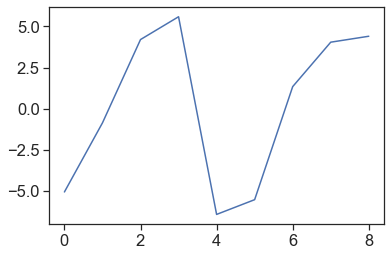

In [30]:
plt.plot(pca_activity[:,3])

In [31]:
pca_dim

5

In [32]:
n_params = int(pca_dim*(pca_dim-1)/2)
basis_tensor_inf = get_basis_tensor(pca_dim)

params = np.random.normal(size=(n_params))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (pca_activity,int(pca_dim),basis_tensor_inf),
           jac=grad_wrapper,
           method='BFGS'
           )
print(res.message)

Desired error not necessarily achieved due to precision loss.


In [33]:
o = np.random.permutation(np.arange(9))
np.allclose(act_matrix[o][:,1],act_matrix[:,1][o])

True

In [34]:
print(res.fun,res.message)

10.284326553344727 Desired error not necessarily achieved due to precision loss.


In [35]:
out = res.x
#out = np.random.normal(size=(n_params))# + np.eye(dim)

skewM = np.einsum('i...,i...',out,basis_tensor_inf)
Ainf = caley_transform(skewM,pca_dim)

In [36]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity.T).T)

In [37]:
#predicted_neural_activity = pca.inverse_transform(pca_activity)

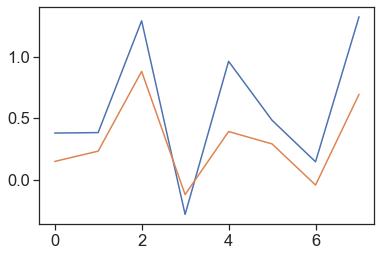

In [38]:
ix_ = 0
plt.plot(predicted_neural_activity[:,ix_][:-1])
plt.plot(act_matrix[:,ix_][1:])

In [39]:
cc = []
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
    
print(np.mean(cc))

0.9208963907761285


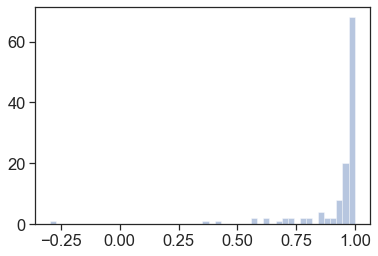

In [40]:
seaborn.distplot(cc,kde=0)

## Now look at the held out task

In [41]:

skewM = np.einsum('i...,i...',out,basis_tensor_inf)
Ainf = caley_transform(skewM,pca_dim)

In [42]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity2.T).T)

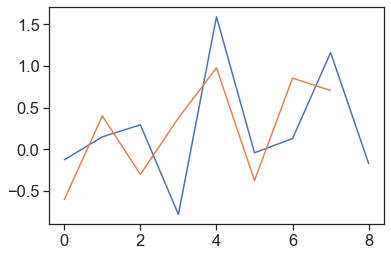

In [43]:
ix_ = 0
plt.plot(predicted_neural_activity[:,ix_])
plt.plot(act_matrix2[:,ix_][1:])

In [44]:
cc = []
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix2[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
print(np.mean(cc))

0.7747294718389017


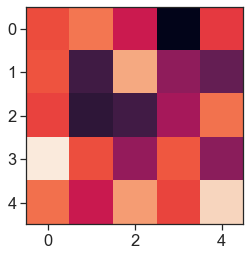

In [57]:
plt.imshow(A)

In [58]:
%store -r act_matrix_ref2

In [59]:
np.allclose(act_matrix2,act_matrix_ref2)

False

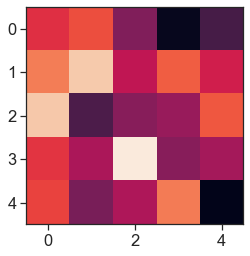

In [54]:
plt.imshow(Ainf)

# Run same test as other data